In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances

from PIL import Image, ImageFont, ImageDraw
from IPython.display import display

import sys
sys.path.append("..")
from dataset.load import LoadDataset
from utils.vis import thumb_grid
from embedding import WSL, VGG16, VGG19, forward
from distances import dist_img

In [3]:
# Get features from dataset
def get_images(n):
    path = "../data/paris_1000_test.h5"
    dataset = LoadDataset(path)
    it = dataset.get()
    idx = []
    images = []
    for i, row in enumerate(it):
        if i >= n: break
        metadata, img, embedding = row
        # ID
        idx.append(metadata["id"])
        # Embedding
        images.append(img)
    return idx, images

idx, images = get_images(200)
len(images)

999

In [4]:
def eval_model_on_dist_img(model, images, dist_method=dist_img):
    model.eval()
    with torch.no_grad():
        embeddings = forward(model, images)
    d = dist_method(embeddings).reshape(-1)
    fig, ax = plt.subplots()
    sns.distplot(d, ax=ax)
    plt.show()

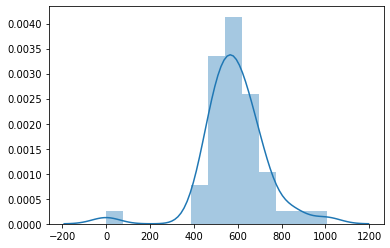

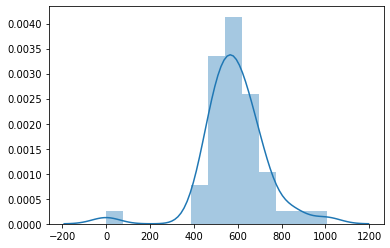

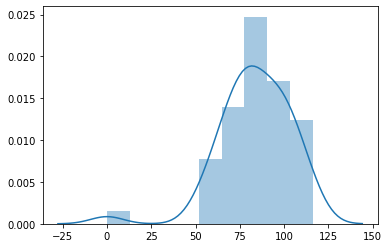

CPU times: user 28.8 s, sys: 3.21 s, total: 32 s
Wall time: 29.1 s


In [6]:
%%time
# VGG19
for model in [VGG19(-30), VGG19(-10), VGG19()]:
    eval_model_on_dist_img(model, images)

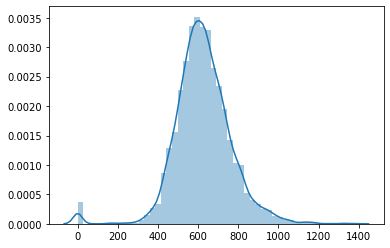

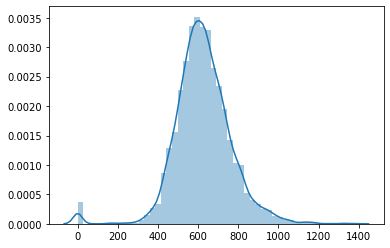

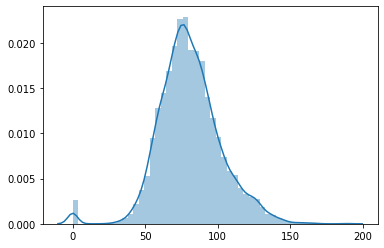

CPU times: user 45.6 s, sys: 5.72 s, total: 51.3 s
Wall time: 47.4 s


In [35]:
%%time
# VGG16
for model in [VGG16(-30), VGG16(-10), VGG16()]:
    eval_model_on_dist_img(model, images)

Using cache found in /Users/sylvainmarchienne/.cache/torch/hub/facebookresearch_WSL-Images_master
Using cache found in /Users/sylvainmarchienne/.cache/torch/hub/facebookresearch_WSL-Images_master


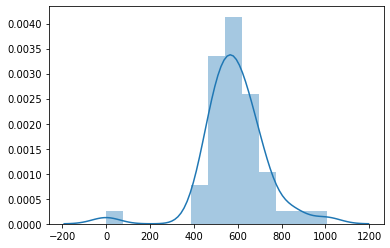

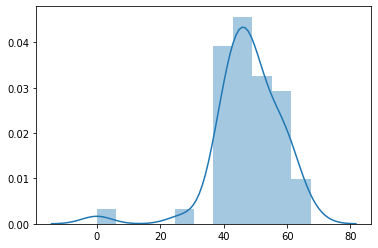

CPU times: user 53.1 s, sys: 7.67 s, total: 1min
Wall time: 59.2 s


In [7]:
%%time
# WSL
for model in [WSL(-30), WSL()]:
    eval_model_on_dist_img(model, images)

# Distance metric

<function cosine_distances at 0x132b414d0>


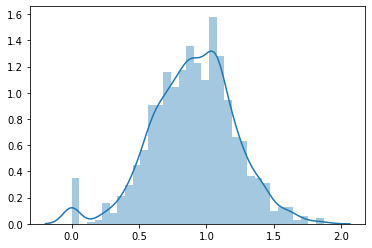

<function euclidean_distances at 0x132b41050>


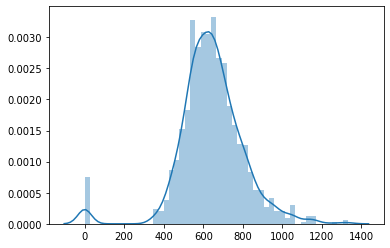

<function manhattan_distances at 0x132b41440>


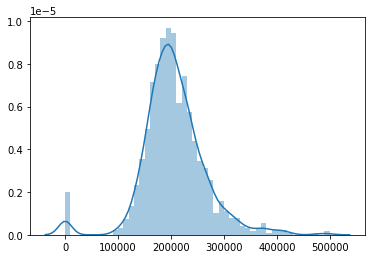

In [6]:
model = VGG16(-30)
for dist_method in [cosine_distances, euclidean_distances, manhattan_distances]:
    print(dist_method)
    eval_model_on_dist_img(model, images, dist_method=dist_method)

# Images

In [86]:
%%time
def eval_model_on_images(model, images, dist_method=dist_img):
    model.eval()
    with torch.no_grad():
        embeddings = forward(model, images)
    d = dist_method(embeddings)
    return d
    
d_VGG16 = eval_model_on_images(VGG16(-10), images)

CPU times: user 19.2 s, sys: 4.02 s, total: 23.2 s
Wall time: 13 s


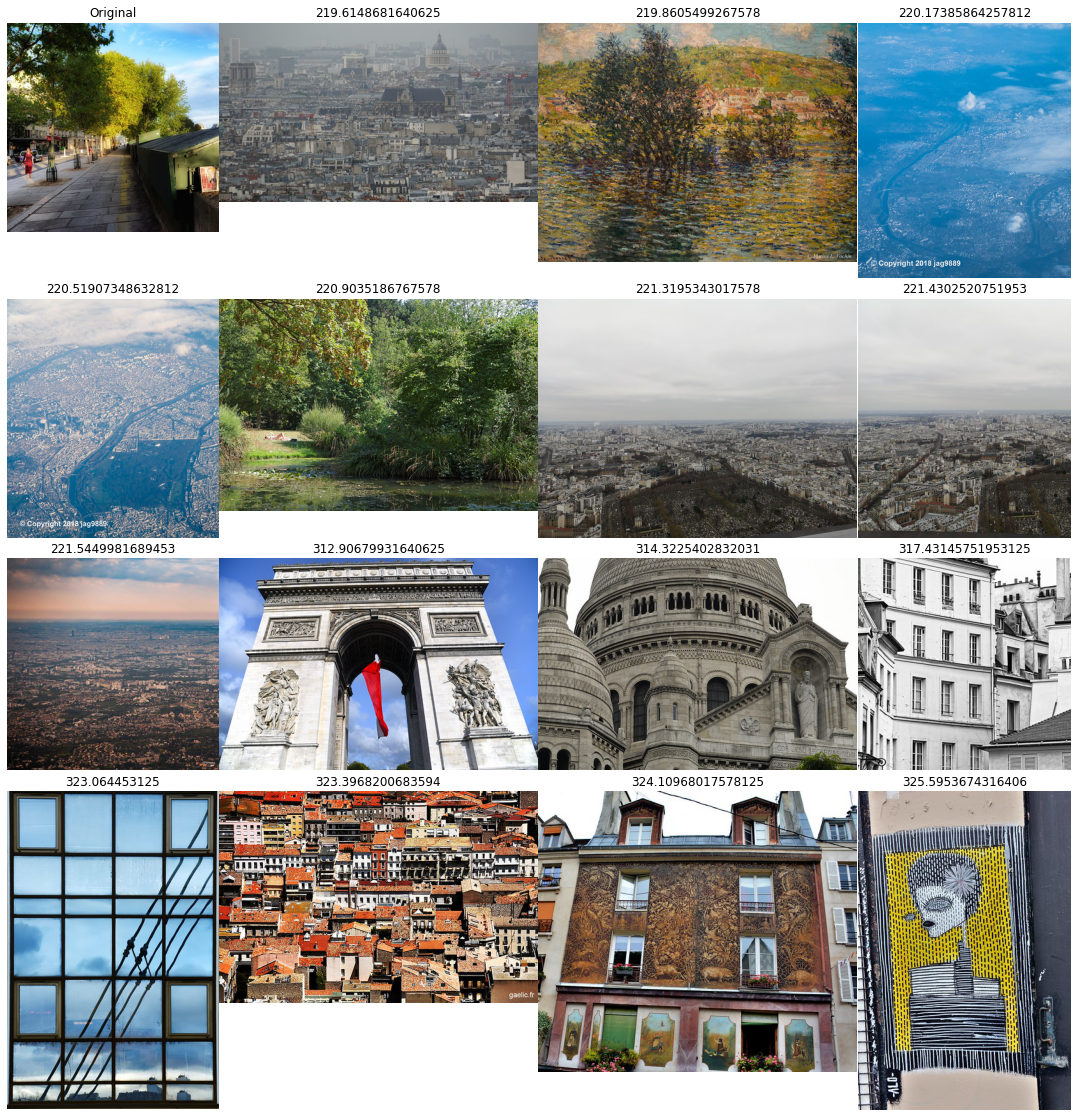

In [96]:
def show_images(distance_matrix):
    np.fill_diagonal(distance_matrix, np.nan)
    i = np.random.choice(d.shape[0], size=1).item()

    to_viz = []
    texts = []
    to_viz.append(images[i])
    texts.append("Original")
    for j in np.argsort(d[i,:])[:8]:
        to_viz.append(images[j])    
        texts.append(f"{d[i,j]}")
    for j in np.argsort(d[i,:])[-8:-1]:
        to_viz.append(images[j])
        texts.append(f"{d[i,j]}")

    fig = thumb_grid(to_viz, (4, 4), txt_list=texts)
    fig.set_size_inches(20, 20)
    plt.show()
    
show_images(d_VGG16)

# Multi-layer

In [16]:
from embedding import VGG16MultiLayer
from distances import compute_distances

model = VGG16MultiLayer()
model.eval()
with torch.no_grad():
    embeddings = forward(model, images, size=(128, 128))
embeddings.shape

(999, 94208)

In [17]:
d_VGG16MultiLayer = compute_distances(embeddings, model.compute_distance)
print(d_VGG16MultiLayer.mean(), d_VGG16MultiLayer.std(), d_VGG16MultiLayer.min(), d_VGG16MultiLayer.max())

238.92124840192952 32.77731976132396 0.0 363.08551025390625


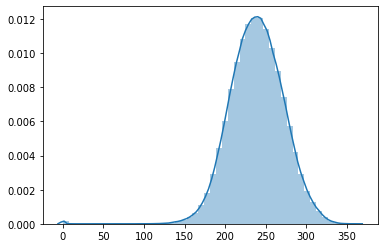

In [18]:
fig, ax = plt.subplots()
sns.distplot(d_VGG16MultiLayer.reshape(-1), ax=ax)
plt.show()

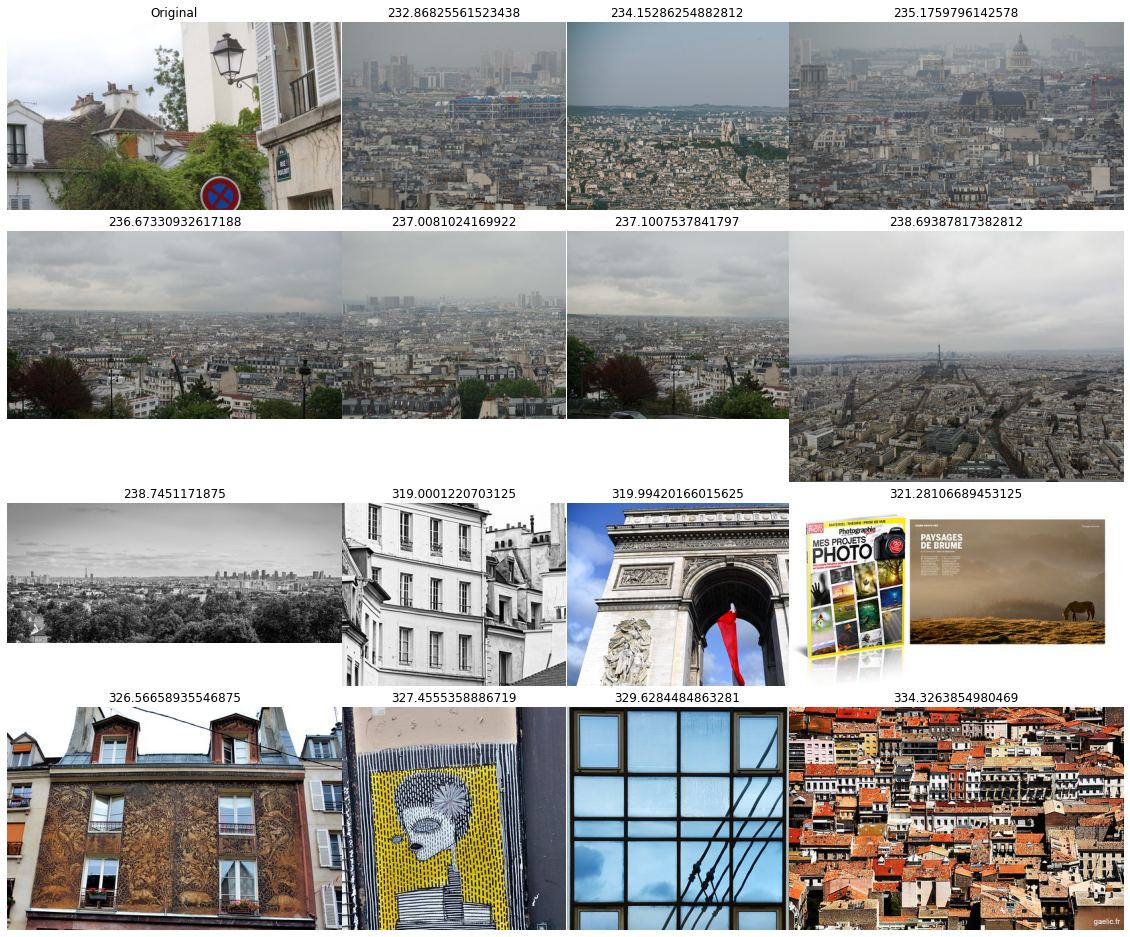

In [83]:
show_images(d_VGG16MultiLayer)